In [51]:
# PyTorch
import torch

# Tensor : ML에 도움이 되는 여러 메서드가 있는 자료구조
"""
torch의 텐서
"""
x = torch.rand(3, 3)
y = torch.ones(3, 3)
print(x)
print(x.T)
print(y)
print(x @ y)




tensor([[0.4626, 0.3058, 0.5229],
        [0.3458, 0.1085, 0.4369],
        [0.1230, 0.2998, 0.1680]])
tensor([[0.4626, 0.3458, 0.1230],
        [0.3058, 0.1085, 0.2998],
        [0.5229, 0.4369, 0.1680]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[1.2914, 1.2914, 1.2914],
        [0.8912, 0.8912, 0.8912],
        [0.5908, 0.5908, 0.5908]])


In [52]:
"""
역전파: backward
"""
x = torch.tensor([2.0, 3.0], requires_grad=True)
y = x ** 2 + 3 * x + 1
z = y.sum()
# backpropagation
z.backward()
# 역전파된 기울기는 .grad에서 확인 가능
print(x.grad)

tensor([7., 9.])


In [53]:
# 장치 관리
device = 'cpu'
# cpu : 복잡한 명령
# gpu : 동시다발적 단순 명령 을 수행
# windows - cuda
if torch.cuda.is_available():
    device = torch.device('cuda')
# apple silicon - mps
if torch.mps.is_available():
    device = torch.device('mps')
print(device)

# x.to(device)

cpu


In [54]:
# 난수 고정
import numpy as np
import random
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# windows - cuda
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# apple silicon - mps
if torch.mps.is_available():
    torch.mps.manual_seed(SEED)
    torch.use_deterministic_algorithms(True, warn_only=True)

In [55]:
"""
선형회귀모델을 PyTorch로 구현
"""

from torch import nn
from torch import optim

In [56]:
# 더미 데이터
X = torch.linspace(0, 10, 100).unsqueeze(1)
# 2*X + 1의 회귀 모델의 구현을 목표로 하는 라벨
y_true = 2 * X + 1 + 0.5 * torch.randn_like(X)

# 1차원 입력, 1차원 출력의 선형 모델을 만들것이다
model = nn.Linear(1, 1)
# 비용 함수는 MSE를 쓸거다
criterion = nn.MSELoss()
# SGD로 파라미터를 갱신할거다
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 학습 시작
epochs = 200
for epoch in range(epochs):
  # 기울기 초기화
  optimizer.zero_grad()

  # 예측
  y_pred = model(X)
  # 손실 계산
  loss = criterion(y_pred, y_true)
  # 비용의 미분 계산
  loss.backward()
  # 매개변수 업뎃
  optimizer.step()
  # 20번의 학습마다 기록
  if (epoch + 1) % 20 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print('학습된 가중치 + 편향')
for name, param in model.named_parameters():
    print(f'{name}: {param.data}')

Epoch [20/200], Loss: 0.7862
Epoch [40/200], Loss: 0.6877
Epoch [60/200], Loss: 0.6071
Epoch [80/200], Loss: 0.5409
Epoch [100/200], Loss: 0.4867
Epoch [120/200], Loss: 0.4423
Epoch [140/200], Loss: 0.4060
Epoch [160/200], Loss: 0.3761
Epoch [180/200], Loss: 0.3517
Epoch [200/200], Loss: 0.3317
학습된 가중치 + 편향
weight: tensor([[2.0866]])
bias: tensor([0.4490])


2.0866057872772217 0.4490278363227844


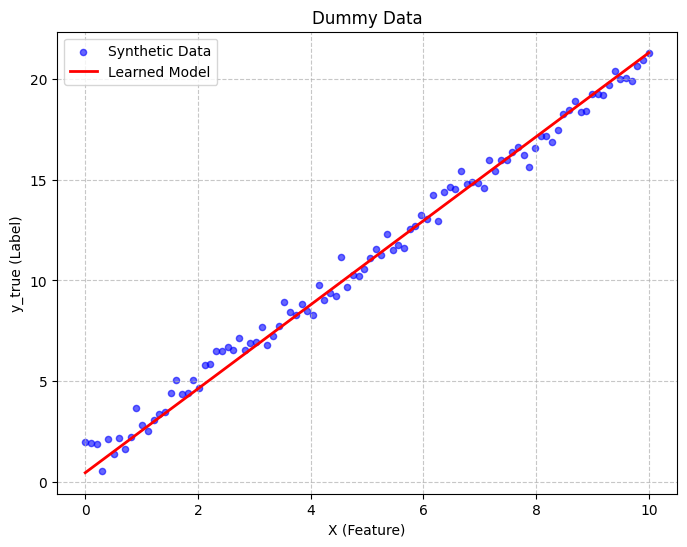

In [57]:
# 실제 데이터와 회귀선 비교
def show_data():
    X_np = X.squeeze().numpy()
    y_true_np = y_true.squeeze().numpy()
    w_learned = model.weight.item()
    b_learned = model.bias.item()
    print(w_learned, b_learned)
    y_line_np = w_learned * X_np + b_learned

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.scatter(X_np, y_true_np, s=20, color='b', alpha=0.6, label='Synthetic Data')
    plt.plot(X_np, y_line_np, color='red', linewidth=2, label=f'Learned Model')

    plt.title('Dummy Data')
    plt.xlabel('X (Feature)')
    plt.ylabel('y_true (Label)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
show_data()

In [58]:
"""
입력 - 은닉 - 출력 구조의 MLP 만들기
"""
import torch
from torch import nn

# 어떤 계층을 넣을지를 결정해서 층 구조를 class로 정의

class SImpleMLP(nn.Module):   # __call__ 참조
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()   # 비선형을 넣기 위해 0미만이면 0으로 이상이면 1로 구분하는?
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    # nn.Module()의 __call__이 호출될 때 자동으로 호출
    def forward(self, x):
        # 각 층을 순차적으로 호출
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class SequetialMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        # 각 층을 순차적으로 쌓는다
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

model = SImpleMLP(20, 10, 1)
# 20개의 feature를 가진 40개의 데이터
X = torch.ones(size=(40, 20))
# 모델을 이용해 예측하기
y_pred = model(X)
# 40개의 데이터에 대한 예측 출력 1개씩 40줄
print(y_pred.size())
y_pred


torch.Size([40, 1])


tensor([[-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150],
        [-0.2150]], grad_fn=<AddmmBackward0>)

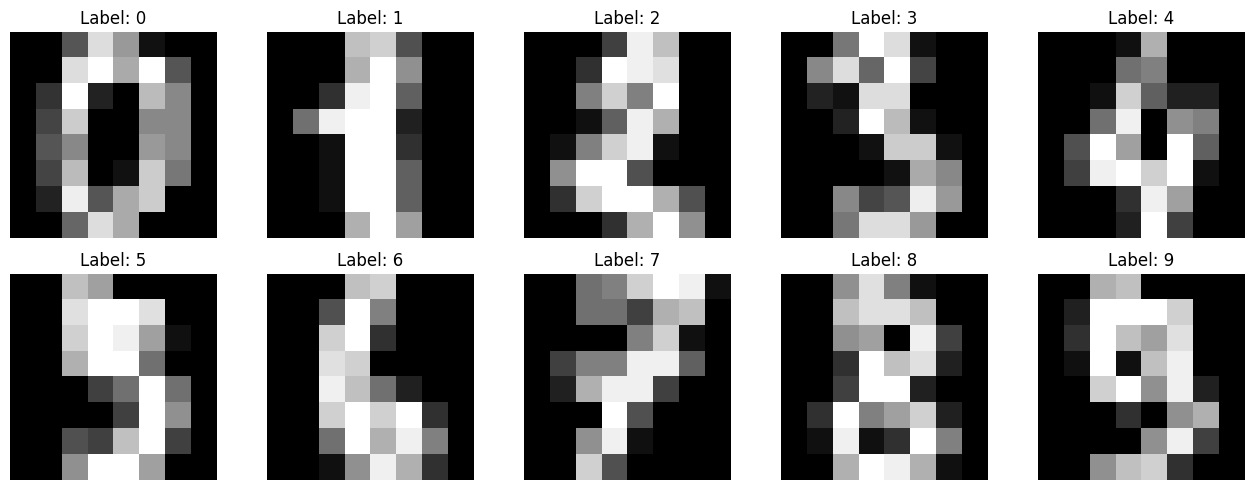

In [59]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data.astype(np.float32)
y = digits.target.astype(np.int64)

fig, ax = plt.subplots(figsize=(13, 5), nrows=2, ncols=5)
for i in range(10):
    ax[i // 5, i % 5].imshow(X[i].reshape(8, 8), cmap="gray")
    ax[i // 5, i % 5].set_title(f"Label: {y[i]}")
    ax[i // 5, i % 5].axis("off")
fig.tight_layout()

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# 남은 2를
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

# 표준화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# 모든 데이터를 텐서로 변환해주세요
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_valid_t = torch.from_numpy(X_valid)
y_valid_t = torch.from_numpy(y_valid)
X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test)

# PyTorch TensorDataset에 넣어주세요

# 하나의 데이터의 기준
# - TensorDataset : index를 기준으로 하나의 샘플 데이터를 구분
from torch.utils.data import TensorDataset
train_ds = TensorDataset(X_train_t, y_train_t)
valid_ds = TensorDataset(X_valid_t, y_valid_t)
test_ds = TensorDataset(X_test_t, y_test_t)

# 아래 설정해준 BATCH_SIZE를 활용해주세요
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [61]:
for idx, batch in enumerate(train_loader):
    print(idx, batch)
    print(len(batch[1]))
    break

0 [tensor([[ 0.0000,  0.7537,  1.4500,  ...,  1.5538,  1.4530, -0.1936],
        [ 0.0000, -0.3305,  0.3895,  ..., -1.1588, -0.5045, -0.1936],
        [ 0.0000, -0.3305, -1.0952,  ...,  0.8757, -0.0152, -0.1936],
        ...,
        [ 0.0000,  0.7537,  0.1774,  ...,  0.1975, -0.5045, -0.1936],
        [ 0.0000, -0.3305, -0.2468,  ...,  1.5538,  3.1659,  4.4432],
        [ 0.0000, -0.3305, -1.0952,  ...,  1.3843,  0.7189, -0.1936]]), tensor([9, 0, 1, 1, 0, 7, 6, 4, 3, 5, 9, 5, 9, 5, 3, 6, 2, 1, 2, 6, 1, 3, 6, 3,
        0, 2, 0, 4, 3, 3, 1, 6])]
32


In [62]:
class MLP(nn.Module):
    def __init__(self,
                 input_dim: int,
                 num_classes: int,
                 hidden_dims=(128, 64),
                 dropout=0.2):
        super().__init__()
        h1, h2 = hidden_dims

        self.net = nn.Sequential(
            # 은닉1
            nn.Linear(input_dim, h1),
            # 활성화 + Dropout
            nn.ReLU(),
            nn.Dropout(p=dropout),
            # 은닉2 (입력 차원은 은닉1의 출력차원)
            nn.Linear(h1, h2),
            # 활성화 + Dropout
            nn.ReLU(),
            nn.Dropout(p=dropout),
            # 출력
            nn.Linear(h2, num_classes),
        )

    def forward(self, x):
        return self.net(x)

In [63]:
# 정답코드
# 4. DataLoader, Model, Optimizer가 주어졌을 때
# 학습데이터에 대해 model을 업데이트하는 코드를 작성해주세요.
def train_one_epoch(model, loader, optimizer, device):
    # 모델이 학습모드로 들어가게 설정해야합니다.
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        # 데이터를 가속화기기로 보내주세요.
        xb, yb = xb.to(device), yb.to(device)

        # 위에서 배운 파라미터 업데이트 방식을 구현해주세요.
        # 1. 모델의 출력 만들어주기
        # 2. 미분값 지워주기 (zero_grad)
        # 3. Loss 계산해주기: loss는 cross_entropy를 사용해주세요
        #   - https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
        # 4. 3에서 계산한 Loss를 기준으로 역전파를 수행합니다.
        # 5. 파라미터 업데이트를 진행해주세요
        optimizer.zero_grad()
        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        loss.backward()
        optimizer.step()

        # 파라미터 업데이트가 끝났으면 몇 가지를 기록해줍니다.
        # 1. batch당 로스 계산 (running_loss에 업데이트)
        # 2. 예측된 클래스 계산 (`preds`)
        # 3. batch 내 정확도 계산 (batch 내에서 정답개수를 correct에 추가)
        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    # 위에서 잘 계산된 값들을 정리해서 반환합니다.
    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

# 정답코드
# 5. 이번에는 모델과 검증/테스트데이터가 입력으로 들어왔을 때 정확도를 계산해주는 코드를 작성해주세요.
def evaluate(model, loader, device):
    # 모델이 추론할 때는 추론모드로 설정해주어야합니다.
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    # 미분그래프를 생성하지 않도록 컨텍스트를 생성해주셔야합니다.
    with torch.no_grad():
        for xb, yb in loader:
            # 데이터로더에서 나온 배치를 `device`로 보내주세요.
            xb, yb = xb.to(device), yb.to(device)

            # 위에서 한 것과 비슷하게
            # 모델의 출력값을 만들어 `logits`에 담고
            # 현재 출력값 `logits`와 `yb` 사이의 Cross Entropy를 계산해주세요.
            logits = model(xb)
            loss = torch.nn.functional.cross_entropy(logits, yb)

            # 이번에도 다음을 기록해줍니다.
            # 1. batch당 로스 계산 (running_loss에 update)
            # 2. 예측된 클래스 계산 (`preds`)
            # 3. batch 내 정확도 계산 (batch 내에서 정답개수를 correct에 추가)
            # 4. 후에 정확한 분류성능을 보기 위해 prediction 값들도 전부 기록해줍니다.
            #  - all_preds, all_targets에 append해줍니다.
            running_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

            all_preds.append(preds.cpu())
            all_targets.append(yb.cpu())

    # 위에서 잘 계산된 값들을 정리해서 반환합니다.
    avg_loss = running_loss / total
    acc = correct / total
    preds_cat = torch.cat(all_preds).numpy()
    targets_cat = torch.cat(all_targets).numpy()
    return avg_loss, acc, preds_cat, targets_cat

In [64]:
# 모든 것을 하나로!
# 여러분이 코드를 잘 짰다면 아래 코드가 잘 작동할겁니다!
# 에러가 뜬다면 에러메시지를 확인해서 잘 구현되도록 맞춰주세요.
import os
import math
import time

from sklearn.metrics import classification_report, confusion_matrix

# device = torch.device("cuda")
model = MLP(
    input_dim=64,
    num_classes=10,
    hidden_dims=(128, 64),
    dropout=0.2
).to(device)

# 이번에는 지난 과제2에서 배웠던 Adam을 사용해봅시다.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

best_val_loss = math.inf
best_val_acc = -1.0
epochs_no_improve = 0

checkpoint_path = "model.ckpt"
earlystop_patience = 5

train_losses, train_accs = [], []
valid_losses, valid_accs = [], []
for epoch in range(1, 201):
    t0 = time.time()
    # 여러분이 정의한 `train_one_epoch`와 `evaluate`입니다.
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss, val_acc, _, _ = evaluate(model, valid_loader, device)
    valid_losses.append(val_loss)
    valid_accs.append(val_acc)

    dt = time.time() - t0
    print(
        f"Epoch {epoch:03d} | "
        f"train loss {train_loss:.4f} acc {train_acc*100:5.2f}% | "
        f"val loss {val_loss:.4f} acc {val_acc*100:5.2f}% | "
        f"{dt:.1f}s"
    )

    # 🌟 개선 시 체크포인트 저장
    improved = (val_loss < best_val_loss) or (val_acc > best_val_acc)
    if improved:
        best_val_loss = min(best_val_loss, val_loss)
        best_val_acc = max(best_val_acc, val_acc)
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_dim': 64,
            'num_classes': 10,
        }, checkpoint_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # 조기 종료
    if epochs_no_improve >= earlystop_patience:
        print(f"Early stopping at epoch {epoch} (no improve {earlystop_patience})")
        break

# 베스트 모델 로드 후 테스트 평가
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    print(f"Loaded best checkpoint: val_best_acc={best_val_acc*100:.2f}% val_best_loss={best_val_loss:.4f}")

test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader, device)
print("\n==== Test Result ====")
print(f"Test loss: {test_loss:.4f}")
print(f"Test acc : {test_acc*100:.2f}%")

# 분류 리포트 / 혼동행렬
print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

Epoch 001 | train loss 1.9191 acc 49.83% | val loss 1.3070 acc 72.78% | 0.2s
Epoch 002 | train loss 0.8077 acc 82.74% | val loss 0.4188 acc 90.56% | 0.1s
Epoch 003 | train loss 0.3364 acc 91.51% | val loss 0.2123 acc 93.89% | 0.1s
Epoch 004 | train loss 0.2106 acc 94.92% | val loss 0.1525 acc 96.11% | 0.1s
Epoch 005 | train loss 0.1553 acc 96.03% | val loss 0.1426 acc 95.00% | 0.1s
Epoch 006 | train loss 0.1166 acc 96.94% | val loss 0.1438 acc 93.89% | 0.1s
Epoch 007 | train loss 0.1056 acc 97.36% | val loss 0.1051 acc 96.67% | 0.1s
Epoch 008 | train loss 0.0810 acc 98.19% | val loss 0.0912 acc 97.78% | 0.1s
Epoch 009 | train loss 0.0706 acc 98.40% | val loss 0.0874 acc 96.67% | 0.1s
Epoch 010 | train loss 0.0675 acc 98.19% | val loss 0.0873 acc 97.22% | 0.1s
Epoch 011 | train loss 0.0532 acc 98.82% | val loss 0.0832 acc 95.56% | 0.1s
Epoch 012 | train loss 0.0497 acc 98.47% | val loss 0.0847 acc 95.56% | 0.1s
Epoch 013 | train loss 0.0459 acc 98.89% | val loss 0.0878 acc 97.22% | 0.1s